# Severstal: Steel Defect Detection

Сталь - один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместным во всем мире. В этом соревновании вы поможете инженерам улучшить алгоритм, локализуя и классифицируя дефекты поверхности на стальном листе.

В этом конкурсе вы будете предсказывать местоположение и тип дефектов, найденных в производстве стали. Изображения названы с помощью уникального ImageID. Вы должны сегментировать и классифицировать дефекты в тестовом наборе.
Каждое изображение может не иметь дефектов, иметь дефект одного класса или дефекты нескольких классов. Для каждого изображения вы должны сегментные дефекты каждого класса (ClassID = [1, 2, 3, 4]).

Сегмент для каждого класса дефекта будет закодирован в один ряд, даже если на изображении есть несколько нереационных дефектов на изображении. Например. «1 3» означает начало с пикселя 1 и всего 3 пикселя (1,2,3).

Набор содержит 12600 изображений.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing import image
from keras.losses import binary_crossentropy

  
from sklearn.model_selection import train_test_split
import random
import os 
from PIL import Image 
from google.colab import drive 
import cv2


import pickle
from tensorflow.keras.utils import plot_model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка и анализ данных

In [ ]:
!unzip -q '/content/drive/MyDrive/Северсталь/Defect.zip'

In [ ]:
train_data = '/content/train_images/'
mask_data = '/content/drive/MyDrive/Северсталь/train.csv/'

In [ ]:
#Читаем файл с данными о масках дефектов
df = pd.read_csv(mask_data + 'train.csv')

In [ ]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
#Проверяем нет ли пропусков в данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [ ]:
#Изображения могут содержать от одного до трех дефектов. Посмотрим как распределяются изображения в зависимости от количества дефектов
print(df.ImageId.value_counts().value_counts())

1    6239
2     425
3       2
Name: ImageId, dtype: int64

In [ ]:
#В выборке есть много изображений, которые не содержат дефектов. Добавим их в нашу таблицу
for name in os.listdir(train_data):  
  if name not in df.ImageId.values:
    new_row = {'ImageId':  name, 'ClassId': 0, 'EncodedPixels': '1 409600'}
    df = df.append(new_row, ignore_index=True)

In [ ]:
#Посмотрим на распределение изображений по классу дефекта (0-дефектов нет)
print(df.ClassId.value_counts())

0    5902
3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [ ]:
#Добавим в таблицу столбец с меткой есть ли дефект или нет
df['defect'] = np.zeros(df.shape[0])
df.loc[df.ClassId != 0, 'defect'] = 1

In [ ]:
#Посмотрим на распределение изображений в зависимости от наличия дефектов
df.drop_duplicates(subset ="ImageId").defect.value_counts()

1.0    6666
0.0    5902
Name: defect, dtype: int64

Видно, что выборка несбалансирована. Очень много дефектов 3 класса и мало 2 класса. 
Одним из пожеланий организатора соревнования была скорость работы модели.   Потому что на один рулон металла приходятся тысячи изображений, а темпы производства таковы, что на оценку качества всего рулона нет и пяти минут.

По логике, на производстве большая часть продукции будет без дефектов. Поэтому можно обучить классификатор, который сразу будет отбирать изображения с дефектами.

Для детекции дефектов будем исопльзовать архитектуру Unet.

Идея заключается в том, чтобы использовать классификатор как backbone для сети Unet и, в случае обнаружения дефекта, не выполнять повторно вычисления по кодированию.

### Получение маски дефекта

In [ ]:
# !mkdir '/content/drive/MyDrive/Северсталь/mask_data'

In [ ]:
#Переведем попиксельное представление маски в изображение
def get_mask(name, data):
  mask = np.zeros(1600*256)
  for class_id, pixels in df.loc[df.ImageId == name, ['ClassId','EncodedPixels']].values:
    if class_id == 0: #Если дефектов нет, оставляем нули в маске
      break
    pixels = np.array(pixels.split(), dtype=np.int32) #получаем данные из соответствующего столбца
    pixels[1::2] += pixels[::2] #получаем индексы окончания строки маски 
    for i in range(0,len(pixels),2):
      mask[pixels[i]+1:pixels[i+1]+2] += class_id #ставим номер класса в нужных пикселях
  mask = mask.reshape(1600,256).T
  return mask


Проверим как работает функция

In [ ]:
name = 'a9f605949.jpg'

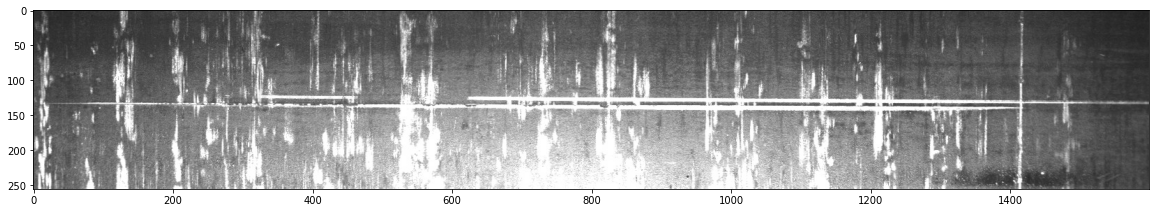

In [ ]:
img = Image.open(train_data + name)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

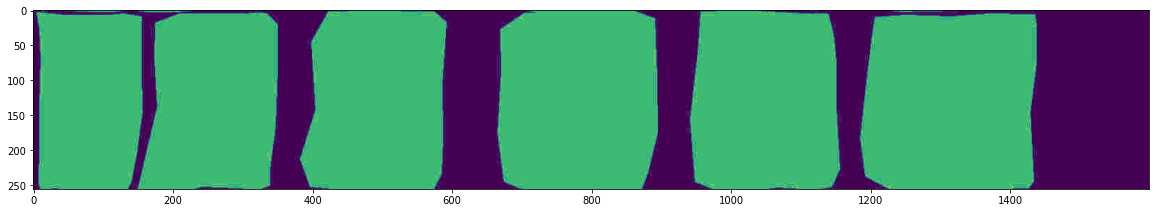

In [ ]:
img = get_mask(name, df)
plt.imshow(img)
plt.rcParams ['figure.figsize'] = [20, 50]
plt.show()

### Разделение на обучающую и тестовую выборки

Так как распределение классов дефектов несбалансированы, будет делать разные обучающие выборки для классификатора и модели сегментации. В тестовую выборку отберем изображения 20% изображенией с сохранением распределения по классам и количеству дефектов на изображении 

In [ ]:
count_to_img = df.ImageId.value_counts()
test_seg = [] #тестовая выборка для задачи сегментации
test_seg.extend(count_to_img[count_to_img==2][:85].index.values) #добавим изображения с двумя дефектами

In [ ]:
#посмотрим какое получилось распределение по класам дефектов
df.loc[df.ImageId.isin(test_seg)].ClassId.value_counts()

3    78
4    58
1    25
2    12
Name: ClassId, dtype: int64

In [ ]:
df_to_split = df.loc[~df.ImageId.isin(test_seg)] #отберем изображения, которых еще нет в тестовой выборке
#добавим недостающее количество изображений в выборку
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 1, 'ImageId'][:153].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 2, 'ImageId'][:36].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 3, 'ImageId'][:951].values)
test_seg.extend(df_to_split.loc[df_to_split.ClassId == 4, 'ImageId'][:102].values)

#создадим тестовую выборку для классификатора
test=test_seg.copy()
test.extend(df_to_split.loc[df_to_split.ClassId == 0, 'ImageId'][:1180].values)

In [ ]:
df_to_seg = df.loc[~df.ImageId.isin(test)] #убираем из набора данных тестовые изображения 

df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 3].index[:3331], axis=0, inplace=True) #делаем undersampling
df_to_seg.drop(df_to_seg.loc[df_to_seg.ClassId == 0].index[:], axis=0, inplace=True) #убираем изображения без дефектов

In [ ]:
#отбираем названия изображений для обучающей выборки модели сегментации
train_seg = df_to_seg.loc[~df_to_seg.ImageId.isin(test), 'ImageId'].values

In [ ]:
#посмотрим на распределение классов в обучающей выборке
df.loc[df.ImageId.isin(train_seg)].ClassId.value_counts()

3    994
1    719
4    630
2    200
Name: ClassId, dtype: int64

In [ ]:
#отбираем названия изображений для обучающей выборки классификатора
train = df.loc[~df.ImageId.isin(test), 'ImageId'].values

In [ ]:
print('Обучающая выборка для сегментации: ', len(train_seg))
print('Тестовая выборка для сегментации: ', len(test_seg))
print('Обучающая выборка для классификатора: ', len(train))
print('Тестовая выборка для классификатора: ', len(test))

Обучающая выборка для сегментации:  10390
Тестовая выборка для сегментации:  1327
Обучающая выборка для классификатора:  10390
Тестовая выборка для классификатора:  2507


### Создание генератора данных

In [ ]:
!pip install albumentations

import albumentations as A

transform_clf = A.Compose([
    A.Resize(width=512, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-10,10), p=0.25,),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform_clf_test = A.Compose([
    A.Resize(width=512, height=256),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

     |████████████████████████████████| 631 kB 4.1 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=f3182fe2cb8a86f55205613213383d05173d862624dc754d87dd598eaf8fa758
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
transform = A.Compose([
    A.Resize(width=512, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-10,10), p=0.25,),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])


transform_test = A.Compose([
    A.Resize(width=512, height=256),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [ ]:
#Создаем словарь {Название изображения: наличие дефекта}
dict_label = dict()
for value in df.values:
  dict_label[value[0]] = value[3]

Создадим два генератора - для сегментации и классификации

In [ ]:
class DataGeneratorSeg(Sequence):
    
    def __init__(self, img_name, data, batch_size=8, shuffle=True, aug=True):
        'Initialization'
        self.img_name = img_name        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.data = data
        self.on_epoch_end()

    def __len__(self):
        #Получаем количество эпох
        return int(np.floor(len(self.img_name) / self.batch_size))

    def __getitem__(self, index):        
        # Получаем индекса батча данных
        list_IDs_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Получаем данные по индексу
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Обновляем и перемешиваем индексы в конце каждой эпохи 
        self.indexes = np.arange(len(self.img_name))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  
    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            #Загружаем данные и меняем размер изображений
            path_img = '/content/train_images/'+self.img_name[i]
            img = cv2.imread(path_img)/255
            label = get_mask(self.img_name[i], self.data)          
         
            #Выполняем аугментацию для обучающей выборки
            if self.aug == True:
                transformed = transform(image=img, mask=label) 
                img = transformed['image']
                label = transformed['mask']
            else:    
                transformed = transform_test(image=img, mask=label) 
                img = transformed['image']
                label = transformed['mask']              
            #Делаем One-Hot-Encoding маски
            labels = np.zeros((256,512,4))
            for i in range(4):
                labels[:,:,i] = (label==i+1).astype(np.int32, copy=False)
            #Добавляем в список
            batch_labels.append(labels)
            batch_imgs.append(img)
                   
        return np.array(batch_imgs), np.array(batch_labels)


In [ ]:
class DataGeneratorClf(Sequence):
    
    def __init__(self, img_name, dict_label, batch_size=8, shuffle=True, aug=True):
        'Initialization'
        self.img_name = img_name
        self.dict_label= dict_label
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        #Получаем количество эпох
        return int(np.floor(len(self.img_name) / self.batch_size))

    def __getitem__(self, index):
        # Получаем индекса батча данных
        list_IDs_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Получаем данные по индексу
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        #Обновляем и перемешиваем индексы в конце каждой эпохи 
        self.indexes = np.arange(len(self.img_name))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

  
    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_labels = list()

        
        for i in list_IDs_temp:
            #Загружаем данные и меняем размер изображения
            path_img = '/content/train_images/'+self.img_name[i]
            img = cv2.imread(path_img)/255
            # Получаем метку классификатора
            labels = self.dict_label[self.img_name[i]]
            #Выполняем аугментацию для обучающей выборки
            if self.aug == True:
                transformed = transform_clf(image=img, mask=np.zeros((256,512,3)), ) 
                img = transformed['image']
            else:    
                transformed = transform_clf_test(image=img, mask=np.zeros((256,512,3))) 
                img = transformed['image']                     
            
            #Добавляем в список
            batch_labels.append(labels)
            batch_imgs.append(img)
                   
        return np.array(batch_imgs), np.array(batch_labels)

In [ ]:
#Создаем генераторы для обучающих и тестовых выборок
train_gen_seg = DataGeneratorSeg(train_seg, df)
test_gen_seg = DataGeneratorSeg(test_seg, df, aug=False)

train_gen_clf = DataGeneratorClf(train,dict_label)
test_gen_clf = DataGeneratorClf(test,dict_label, aug=False)

### Создание и обучение моделей

In [ ]:
#Задаем метрику и функцию потерь

# Функция считает степень пересечения настоящей и предсказанной маски
def dice_coef(true, pred):
  return (2 * K.sum(true*pred)+1) / (K.sum(true) + K.sum(pred)+1)

# Функция потерь составная
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 0.25*(1-dice_coef(y_true, y_pred))

#### Классификатор

In [ ]:
!pip install segmentation-models

In [ ]:
from segmentation_models import Unet
unet = Unet(backbone_name='efficientnetb1', classes=4, encoder_weights=None, encoder_freeze=False)


In [ ]:
#Добавим требуемых выход модели
x = unet.layers[-42].output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

clf = Model(model.input, output)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=0,
                                mode="auto", min_delta=0.0001, cooldown=0, min_lr=0)
save_callback = ModelCheckpoint('/content/drive/MyDrive/Северсталь/best_clf.hdf5', monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto')
callbacks = [lr_callback, save_callback]

In [ ]:
clf.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = clf.fit(train_gen_clf, validation_data=test_gen_clf, epochs=80, callbacks=callbacks)

Epoch 1/80
1298/1298 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.5711
Epoch 1: val_loss improved from inf to 0.64767, saving model to /content/drive/MyDrive/Северсталь/best_clf.hdf5
1298/1298 [==============================] - 398s 280ms/step - loss: 0.7845 - accuracy: 0.5711 - val_loss: 0.6477 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 2/80
1298/1298 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.6558
Epoch 2: val_loss improved from 0.64767 to 0.58348, saving model to /content/drive/MyDrive/Северсталь/best_clf.hdf5
1298/1298 [==============================] - 361s 278ms/step - loss: 0.6429 - accuracy: 0.6558 - val_loss: 0.5835 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 3/80
1298/1298 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.6839
Epoch 3: val_loss improved from 0.58348 to 0.49020, saving model to /content/drive/MyDrive/Северсталь/best_clf.hdf5
1298/1298 [==============================] - 363s 280ms/step -

In [ ]:
# clf.save_weights('/content/drive/MyDrive/Северсталь/encoder.h5')
clf.load_weights('/content/drive/MyDrive/Северсталь/encoder.h5')

In [ ]:
#Функция выводит графики обучения модели
def plot_history(history, num_epoch):
  plt.figure(figsize=(18, 6))
  name = list(history.keys())
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(history[name[i]])
    plt.plot(history[name[i+2]])
    plt.xlabel("Эпоха")
    plt.ylabel("{}".format(name[i]))
    plt.xticks(range(0,num_epoch, 5))
    plt.legend(['Обучающая выборка','Тестовая выборка'])
  plt.show()

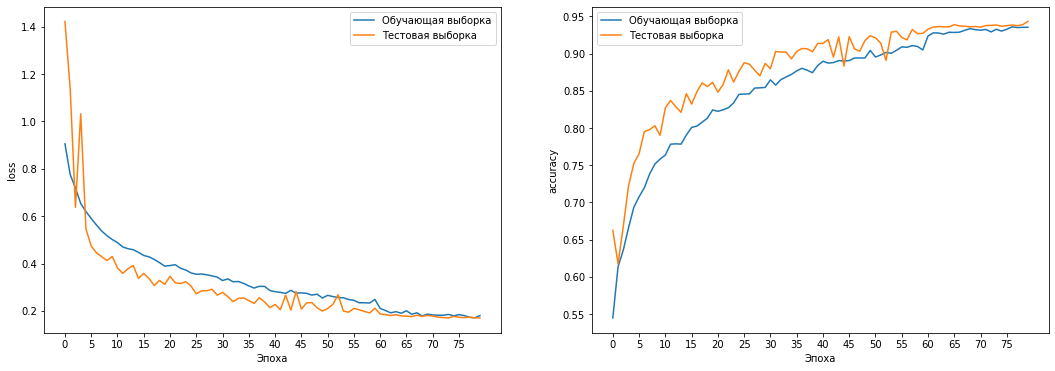

In [ ]:
plot_history(hist, 80)

### Cегментация

In [ ]:
clf.load_weights('/content/drive/MyDrive/Северсталь/best_clf.hdf5')
for layer in clf.layers:
    layer.trainable = False

In [ ]:
save_callback = ModelCheckpoint('/content/drive/MyDrive/Северсталь/best_unet.hdf5', monitor='val_dice_coef', verbose=1,
                                save_best_only=True, mode='max')
callbacks = [lr_callback, save_callback]

In [ ]:
unet.compile(optimizer=Adam(0.0001), loss=bce_dice_loss, metrics=[dice_coef])
history = unet.fit(train_gen_seg, validation_data=test_gen_seg, epochs=60, callbacks=callbacks)

Epoch 1/60
292/292 [==============================] - ETA: 0s - loss: 0.1256 - dice_coef: 0.6223
Epoch 1: val_dice_coef improved from 0.61485 to 0.62083, saving model to /content/drive/MyDrive/Северсталь/best_unet.hdf5
292/292 [==============================] - 139s 432ms/step - loss: 0.1256 - dice_coef: 0.6223 - val_loss: 0.1304 - val_dice_coef: 0.6208 - lr: 1.0000e-04
Epoch 2/60
292/292 [==============================] - ETA: 0s - loss: 0.1220 - dice_coef: 0.6319
Epoch 2: val_dice_coef improved from 0.62083 to 0.62340, saving model to /content/drive/MyDrive/Северсталь/best_unet.hdf5
292/292 [==============================] - 124s 423ms/step - loss: 0.1220 - dice_coef: 0.6319 - val_loss: 0.1295 - val_dice_coef: 0.6234 - lr: 1.0000e-04
Epoch 3/60
292/292 [==============================] - ETA: 0s - loss: 0.1230 - dice_coef: 0.6278
Epoch 3: val_dice_coef improved from 0.62340 to 0.62426, saving model to /content/drive/MyDrive/Северсталь/best_unet.hdf5
292/292 [==========================

KeyboardInterrupt: ignored

In [ ]:
model.load_weights('/content/drive/MyDrive/Северсталь/best_unet.hdf5')

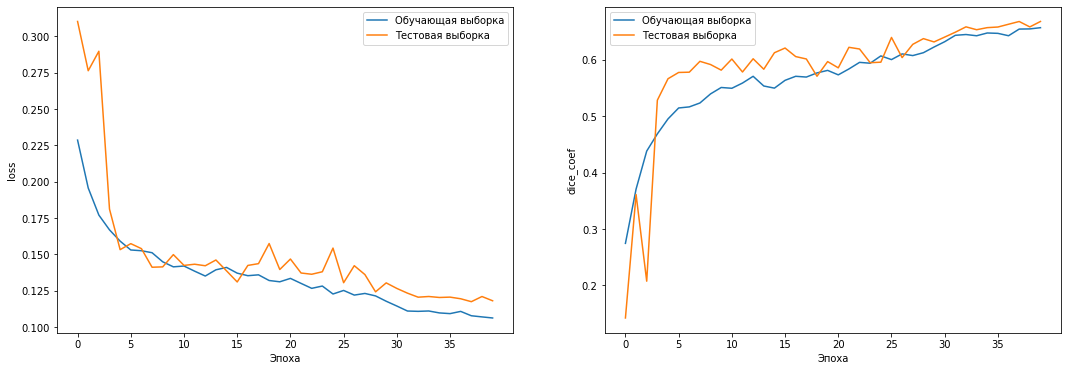

In [ ]:
plot_history(hist, 40)

In [ ]:
def get_predict(img):

  unet_pred, clf_pred = model.predict(img)
  if np.array(clf_pred[0]) > 0.5:
    seg_pred = unet_pred
    pred_mask = (seg_pred[0] > 0.5).astype(np.int32)
    pred_mask = pred_mask[:,:,0] + pred_mask[:,:,1]*2+ pred_mask[:,:,2]*3+ pred_mask[:,:,3]*4
    pred_mask = pred_mask.astype(np.float32)
    pred_mask = cv2.resize(pred_mask, (1600,256), cv2.INTER_NEAREST)
    pred_mask[(pred_mask != 1) & (pred_mask != 2) & (pred_mask != 3) & (pred_mask != 4)] = 0 

  else: pred_mask = np.zeros((256,1600))

  return pred_mask


In [ ]:
def plot_predict(list_name, length=2508):
  n = random.randint(0, length)
  name = list_name[n]

  path_img = '/content/train_images/' + name
  mask = get_mask(name, df)

  orig_img = cv2.imread(path_img)/255
  img = cv2.resize(orig_img, (512,256), cv2.INTER_NEAREST) 
  img = img.reshape(1,256,512,3)

  pred_mask = get_predict(img)


  plt.figure(figsize=(30, 15))
  plt.subplot(3,1,1)
  plt.imshow(orig_img)
  plt.title('Оригинальное изображение')
  plt.subplot(3,1,2)
  plt.imshow(mask*60, cmap='jet')
  plt.title('Настоящая маска')
  plt.subplot(3,1,3)
  plt.imshow(pred_mask*60, cmap='jet')
  plt.title('Предсказаная маска')

  plt.show()
  

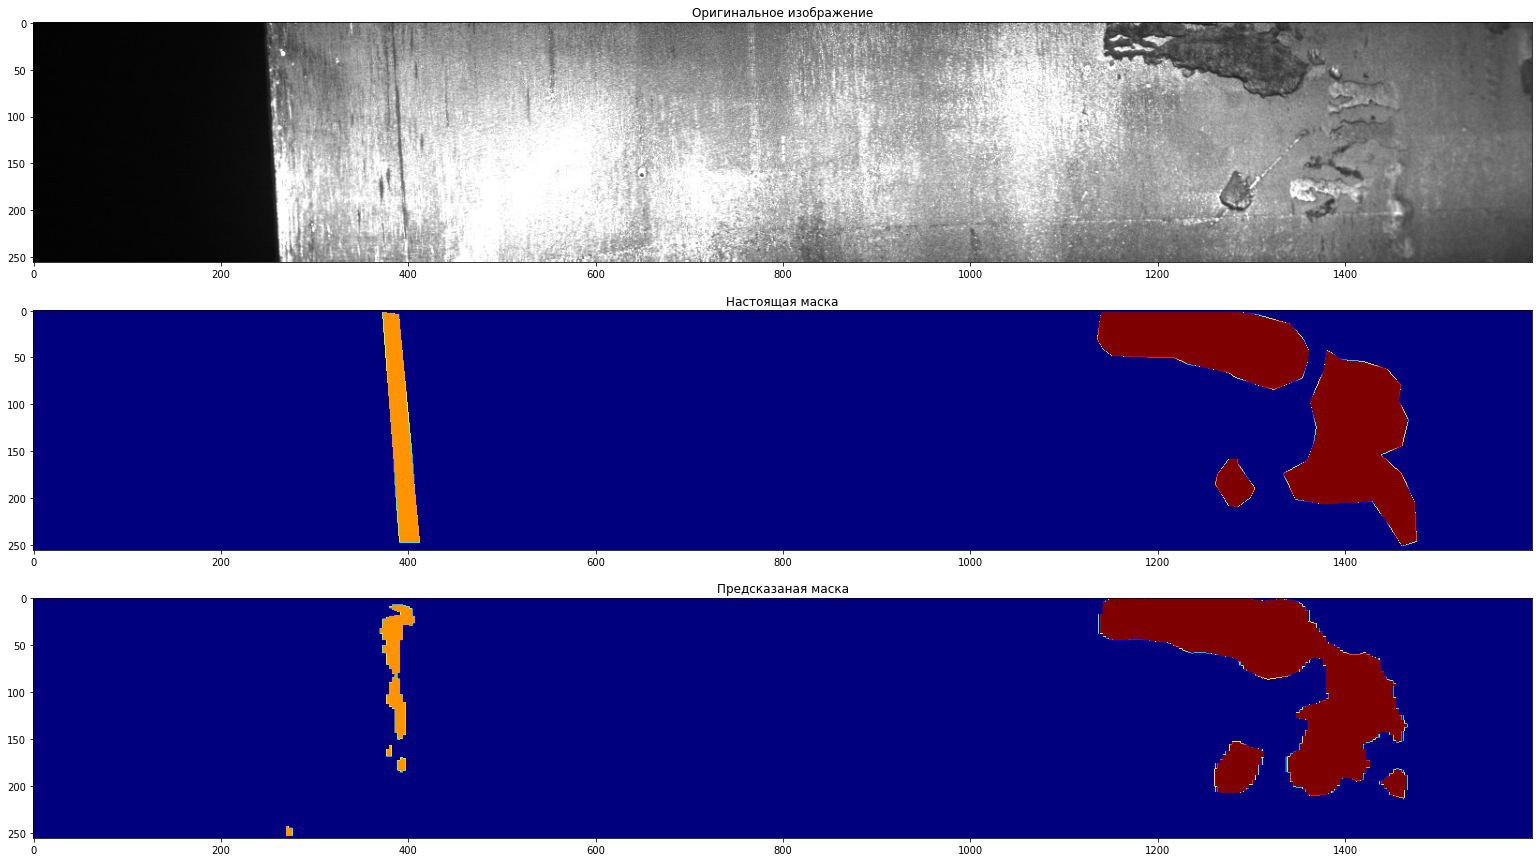

CPU times: user 933 ms, sys: 19.6 ms, total: 952 ms
Wall time: 934 ms


In [ ]:
%%time
plot_predict(test_seg, 80)

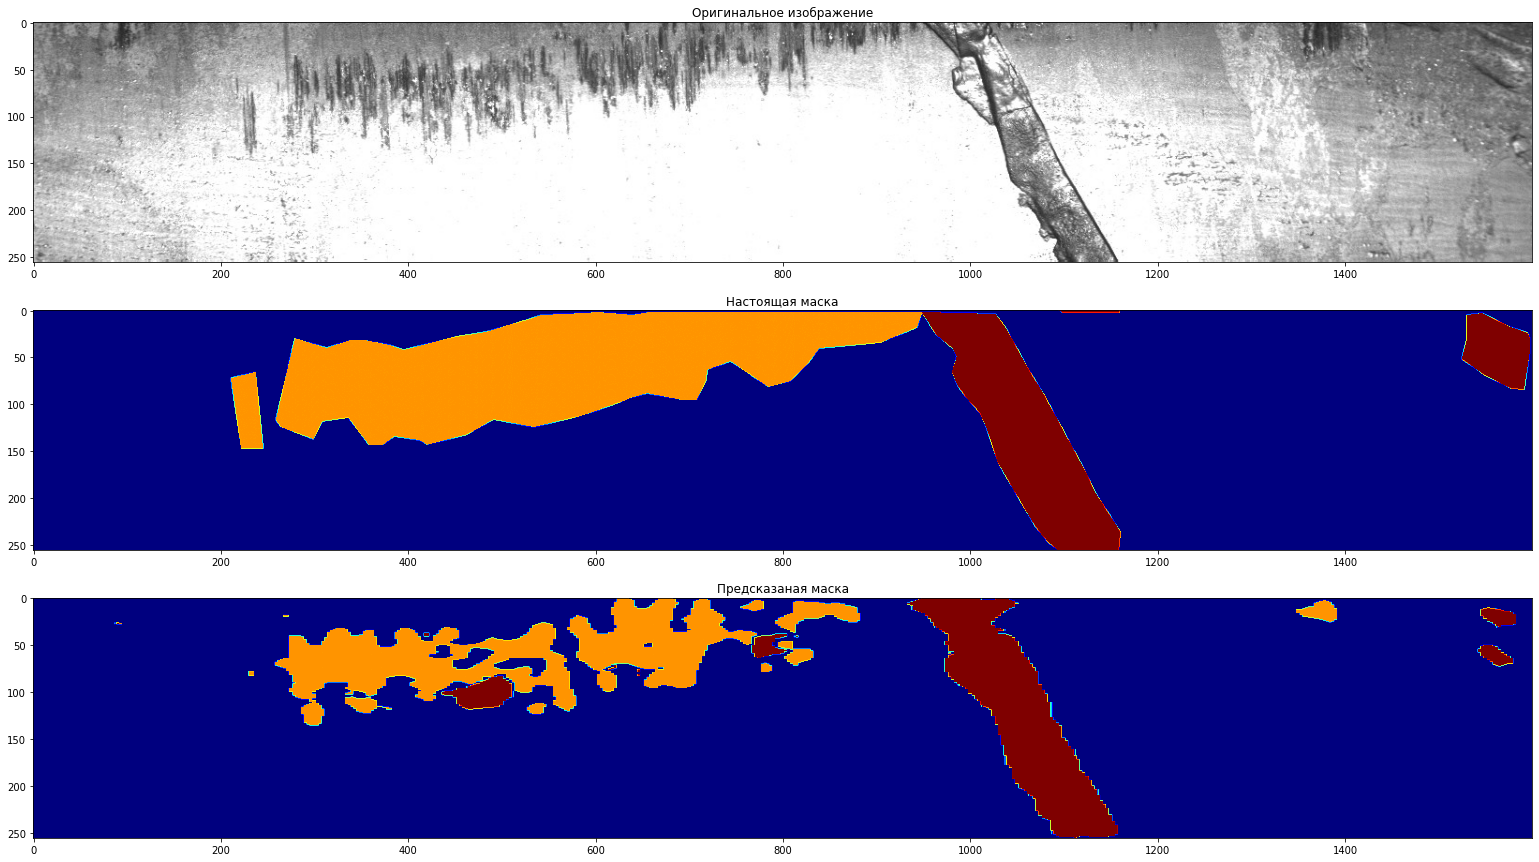

In [ ]:
plot_predict(test_seg, 80)